# CEO-Request Challenge

## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

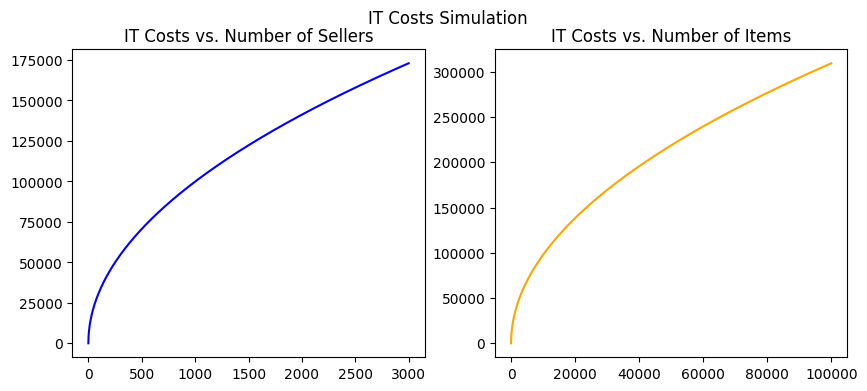

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

In [2]:
from olist.seller import Seller

# Seller sınıfını başlat
seller = Seller()

# Güncellenmiş get_training_data methodunu çağır
# Bu işlem arka planda revenues, cost_of_reviews ve profits hesaplamalarını yapacak
sellers = seller.get_training_data()

# Yeni oluşturduğumuz finansal sütunları kontrol edelim
print(sellers[['revenues', 'cost_of_reviews', 'profits']].head())

# Veri setinin genel durumuna bakalım
print(f"Toplam Satıcı Sayısı: {sellers.shape[0]}")
sellers.head()

      revenues  cost_of_reviews      profits
0   333.472099              140   193.472099
1  2329.649191              240  2089.649191
2    15.800000                0    15.800000
3     7.999000                0     7.999000
4    16.799000              100   -83.201000
Toplam Satıcı Sayısı: 2967


,seller_id,seller_city,seller_state,wait_time,delay_to_carrier,date_first_sale,date_last_sale,months_on_olist,share_of_five_stars,share_of_one_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,13.018588,1.235586,2017-05-05 16:25:11,2017-08-30 12:50:19,3.895026,0.333333,0.333333,3.000000,140,3,3,1.000,218.70,333.472099,193.472099
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,9.065716,0.065167,2017-03-29 02:10:34,2018-06-06 20:15:21,14.491777,0.731707,0.048780,4.560976,240,40,41,1.025,11703.07,2329.649191,2089.649191
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,4.042292,0.000000,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,0.000000,5.000000,0,1,1,1.000,158.00,15.800000,15.800000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,5.667187,0.000000,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,0.000000,5.000000,0,1,1,1.000,79.99,7.999000,7.999000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,35.314861,7.817743,2017-11-14 12:15:25,2017-11-14 12:15:25,0.000000,0.000000,1.000000,1.000000,100,1,1,1.000,167.99,16.799000,-83.201000


### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

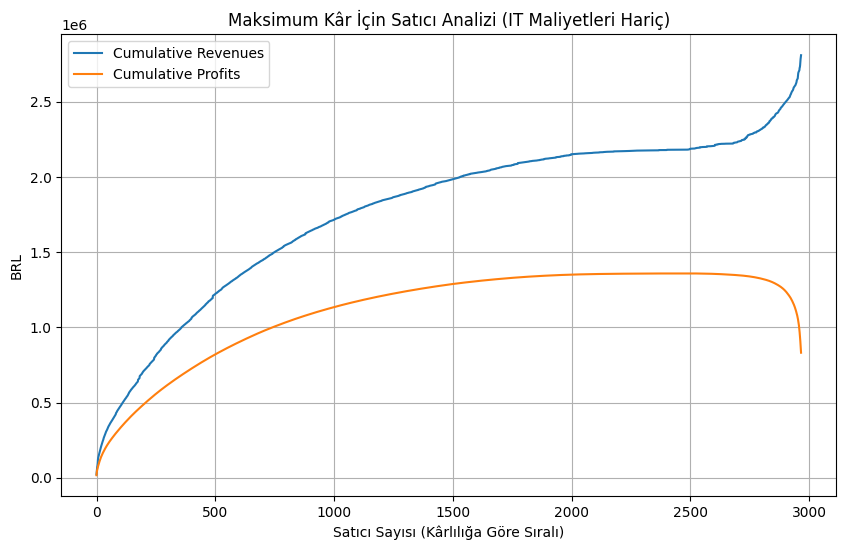

--- ANALİZ SONUÇLARI (IT Maliyeti Hariç) ---
Optimum Satıcı Sayısı : 2490
Maksimum Net Profit   : 1,358,003.30 BRL
Total Revenues        : 2,181,023.30 BRL
Satılan Ürün Adedi    : 58,879

Mevcut Satıcı Sayısı  : 2967
Mevcut Net Profit     : 831,263.49 BRL


In [3]:
# 1️⃣ Sıralama (Sorting)
# En çok kâr ettiren satıcı en üstte olacak şekilde sıralıyoruz.
# Reset index yaparak x ekseninin "Satıcı Sayısı"nı (0, 1, 2...) temsil etmesini sağlıyoruz.
sellers_sorted = sellers.sort_values(by='profits', ascending=False).reset_index(drop=True)

# 2️⃣ Kümülatif Hesaplamalar (Cumulative Sums)
# .cumsum() fonksiyonu, satır satır ilerleyerek değerleri toplar.
sellers_sorted['cum_revenues'] = sellers_sorted['revenues'].cumsum()
sellers_sorted['cum_profits'] = sellers_sorted['profits'].cumsum()
sellers_sorted['cum_quantity'] = sellers_sorted['quantity'].cumsum()

# 3️⃣ Görselleştirme (Plotting)
# Gelir ve Kâr eğrilerini çizdirelim.
plt.figure(figsize=(10, 6))
sellers_sorted['cum_revenues'].plot(label='Cumulative Revenues')
sellers_sorted['cum_profits'].plot(label='Cumulative Profits')
plt.title("Maksimum Kâr İçin Satıcı Analizi (IT Maliyetleri Hariç)")
plt.xlabel("Satıcı Sayısı (Kârlılığa Göre Sıralı)")
plt.ylabel("BRL")
plt.legend()
plt.grid(True)
plt.show()

# 4️⃣ Optimum Noktayı Belirleme (Optimization)
# Kümülatif kârın zirve yaptığı (maksimum olduğu) indexi bulalım.
idx_max = np.argmax(sellers_sorted['cum_profits'])

# İndeks 0'dan başladığı için satıcı sayısı index + 1 olur.
optimum_seller_count = idx_max + 1

# O noktadaki değerleri çekelim
optimum_profit = sellers_sorted.loc[idx_max, 'cum_profits']
optimum_revenue = sellers_sorted.loc[idx_max, 'cum_revenues']
optimum_items = sellers_sorted.loc[idx_max, 'cum_quantity']

print("--- ANALİZ SONUÇLARI (IT Maliyeti Hariç) ---")
print(f"Optimum Satıcı Sayısı : {optimum_seller_count}")
print(f"Maksimum Net Profit   : {optimum_profit:,.2f} BRL")
print(f"Total Revenues        : {optimum_revenue:,.2f} BRL")
print(f"Satılan Ürün Adedi    : {optimum_items:,.0f}")

# Karşılaştırma için mevcut durumu (tüm satıcılar) da yazdıralım
total_sellers = len(sellers)
current_profit = sellers_sorted['cum_profits'].iloc[-1]
print(f"\nMevcut Satıcı Sayısı  : {total_sellers}")
print(f"Mevcut Net Profit     : {current_profit:,.2f} BRL")

### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


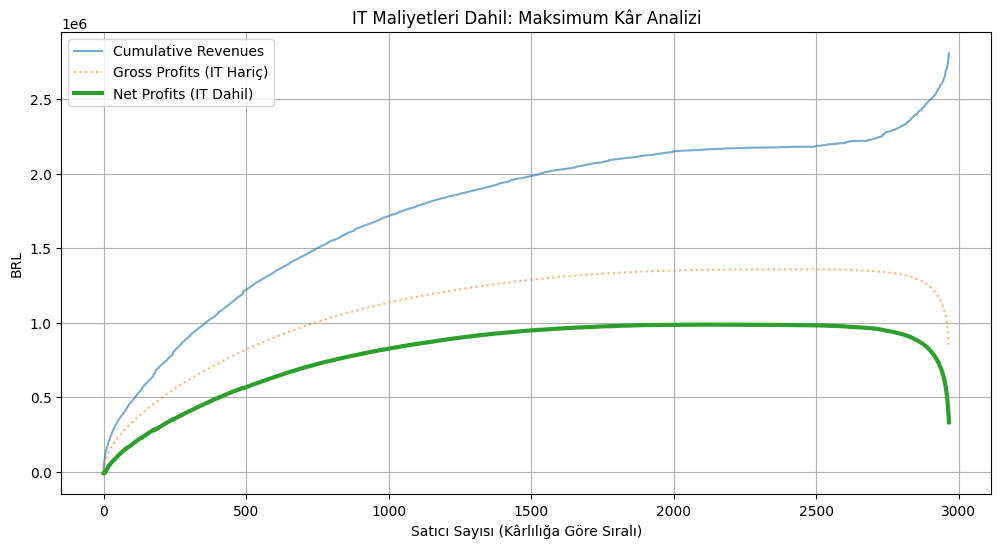

--- FİNAL ANALİZ SONUÇLARI (IT Maliyeti Dahil) ---
Optimum Satıcı Sayısı     : 2117 (Toplam 2967 satıcıdan)
Çıkarılacak Satıcı Sayısı : 850
----------------------------------------
Maksimum Net Profit       : 986,736.70 BRL
IT Öncesi Gross Profit    : 1,354,295.95 BRL
Hesaplanan IT Maliyeti    : 367,559.25 BRL
Total Revenues            : 2,161,665.95 BRL
Satılan Item Sayısı       : 57,856


In [4]:
# 1️⃣ IT Maliyet Fonksiyonunu Tanımlayalım
# Olist'in toplam IT maliyetini yaklaşık 500.000 BRL olarak varsayıyoruz.
# Maliyetin hem satıcı sayısının hem de ürün sayısının karekökü ile orantılı arttığını modelliyoruz.

def calculate_it_costs(n_sellers, n_items, total_global_it_costs=500000):
    """
    Sistemin ölçeğine göre IT maliyetini hesaplar.
    Maliyet, satıcı ve ürün sayısının kareköküyle orantılı olarak ölçeklenir (Sub-linear scaling).
    """
    # Mevcut verisetindeki toplam değerler (Scaling faktörünü bulmak için)
    total_sellers_count = sellers['seller_id'].nunique()
    total_items_count = sellers['quantity'].sum()
    
    # Ölçekleme faktörü (Global maliyeti mevcut karekök toplamlarına bölüyoruz)
    # Bu formül, maliyeti tüm sisteme dağıtır.
    scaling_factor = total_global_it_costs / (np.sqrt(total_sellers_count) + np.sqrt(total_items_count))
    
    # İstenen n_sellers ve n_items için maliyet hesabı
    cost = scaling_factor * (np.sqrt(n_sellers) + np.sqrt(n_items))
    return cost

# 2️⃣ Sıralama (Maliyet öncesi kâra göre)
# Yine en kârlı satıcıdan başlayarak sıralıyoruz
sellers_sorted = sellers.sort_values(by='profits', ascending=False).reset_index(drop=True)

# 3️⃣ Kümülatif Hesaplamalar (Cumulative Sums)
sellers_sorted['cum_revenues'] = sellers_sorted['revenues'].cumsum()
sellers_sorted['cum_profits_gross'] = sellers_sorted['profits'].cumsum() # IT öncesi brüt kâr
sellers_sorted['cum_quantity'] = sellers_sorted['quantity'].cumsum()

# Satıcı sayısını kümülatif olarak (1, 2, 3...) temsil eden bir sütun ekleyelim
sellers_sorted['cum_sellers'] = np.arange(1, len(sellers_sorted) + 1)

# 4️⃣ IT Maliyetlerinin ve Net Kârın Hesaplanması
# Apply kullanmak yerine vektörel işlem yapıyoruz (daha hızlı)
sellers_sorted['cum_it_costs'] = calculate_it_costs(
    sellers_sorted['cum_sellers'], 
    sellers_sorted['cum_quantity']
)

# Nihai Net Kâr (Gross Profit - IT Costs)
sellers_sorted['cum_profits_net'] = sellers_sorted['cum_profits_gross'] - sellers_sorted['cum_it_costs']

# 5️⃣ Görselleştirme
plt.figure(figsize=(12, 6))
sellers_sorted['cum_revenues'].plot(label='Cumulative Revenues', alpha=0.6)
sellers_sorted['cum_profits_gross'].plot(label='Gross Profits (IT Hariç)', linestyle=':', alpha=0.6)
sellers_sorted['cum_profits_net'].plot(label='Net Profits (IT Dahil)', linewidth=3) # Ana odak noktamız
plt.title("IT Maliyetleri Dahil: Maksimum Kâr Analizi")
plt.xlabel("Satıcı Sayısı (Kârlılığa Göre Sıralı)")
plt.ylabel("BRL")
plt.legend()
plt.grid(True)
plt.show()

# 6️⃣ Optimum Noktayı Belirleme (IT Sonrası)
idx_max_net = np.argmax(sellers_sorted['cum_profits_net'])
opt_seller_count = sellers_sorted.loc[idx_max_net, 'cum_sellers']

# Sonuçları Çekelim
final_net_profit = sellers_sorted.loc[idx_max_net, 'cum_profits_net']
final_gross_profit = sellers_sorted.loc[idx_max_net, 'cum_profits_gross']
final_it_cost = sellers_sorted.loc[idx_max_net, 'cum_it_costs']
final_revenue = sellers_sorted.loc[idx_max_net, 'cum_revenues']
final_items = sellers_sorted.loc[idx_max_net, 'cum_quantity']

print("--- FİNAL ANALİZ SONUÇLARI (IT Maliyeti Dahil) ---")
print(f"Optimum Satıcı Sayısı     : {opt_seller_count} (Toplam {len(sellers)} satıcıdan)")
print(f"Çıkarılacak Satıcı Sayısı : {len(sellers) - opt_seller_count}")
print("-" * 40)
print(f"Maksimum Net Profit       : {final_net_profit:,.2f} BRL")
print(f"IT Öncesi Gross Profit    : {final_gross_profit:,.2f} BRL")
print(f"Hesaplanan IT Maliyeti    : {final_it_cost:,.2f} BRL")
print(f"Total Revenues            : {final_revenue:,.2f} BRL")
print(f"Satılan Item Sayısı       : {final_items:,.0f}")

## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

### **1. Kâr Eden vs. Zarar Ettiren Satıcı Dağılımı**

*Verilerimize göre satıcıların önemli bir kısmı, yarattıkları kötü yorum maliyetleri (review costs) sebebiyle aslında şirkete zarar ettirmektedir. Bu dağılımı görmek, problemin büyüklüğünü anlamamızı sağlar.*

/tmp/ipykernel_76539/1622056346.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=profit_counts.index, y=profit_counts.values, palette=colors)


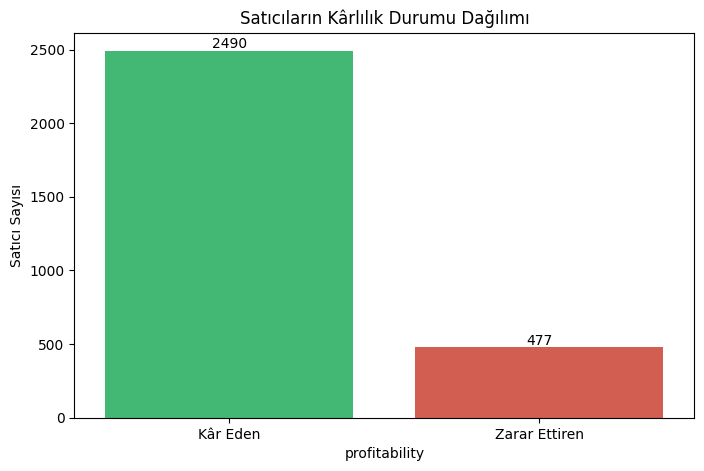

Toplam Satıcı: 2967
Zarar Ettiren Satıcı Oranı: %16.1


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Profit durumuna göre etiketleme
sellers['profitability'] = sellers['profits'].apply(lambda x: 'Kâr Eden' if x > 0 else 'Zarar Ettiren')

# Sayıları hesapla
profit_counts = sellers['profitability'].value_counts()

# Görselleştirme
plt.figure(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c'] # Yeşil ve Kırmızı
ax = sns.barplot(x=profit_counts.index, y=profit_counts.values, palette=colors)

plt.title("Satıcıların Kârlılık Durumu Dağılımı")
plt.ylabel("Satıcı Sayısı")

# Barların üzerine sayıları yaz
for i in ax.containers:
    ax.bar_label(i,)

plt.show()

print(f"Toplam Satıcı: {len(sellers)}")
print(f"Zarar Ettiren Satıcı Oranı: %{(profit_counts['Zarar Ettiren'] / len(sellers) * 100):.1f}")

### **2. Kaç Satıcının Platformdan Atılması Gerektiği**

*2.3 numaralı analizimizde (IT maliyetleri dahil), kümülatif kârın zirve yaptığı noktayı bulmuştuk. Bu noktanın ötesindeki tüm satıcılar, marjinal olarak sisteme yük getirmektedir ve çıkarılmalıdır.*

             📉 OLIST SATICI OPTİMİZASYON RAPORU             
✅ Tutulması Gereken Optimum Satıcı Sayısı : 2117
❌ Platformdan Çıkarılması Gereken         : 850
📊 Çıkarılacak Satıcı Oranı                : %28.6
------------------------------------------------------------
💰 Optimize Edilmiş Tahmini Net Kâr        : 986,736.70 BRL
📉 Mevcut Durumdaki Net Kâr                : 331,263.49 BRL
🚀 Potansiyel Kâr Artışı                   : 655,473.21 BRL


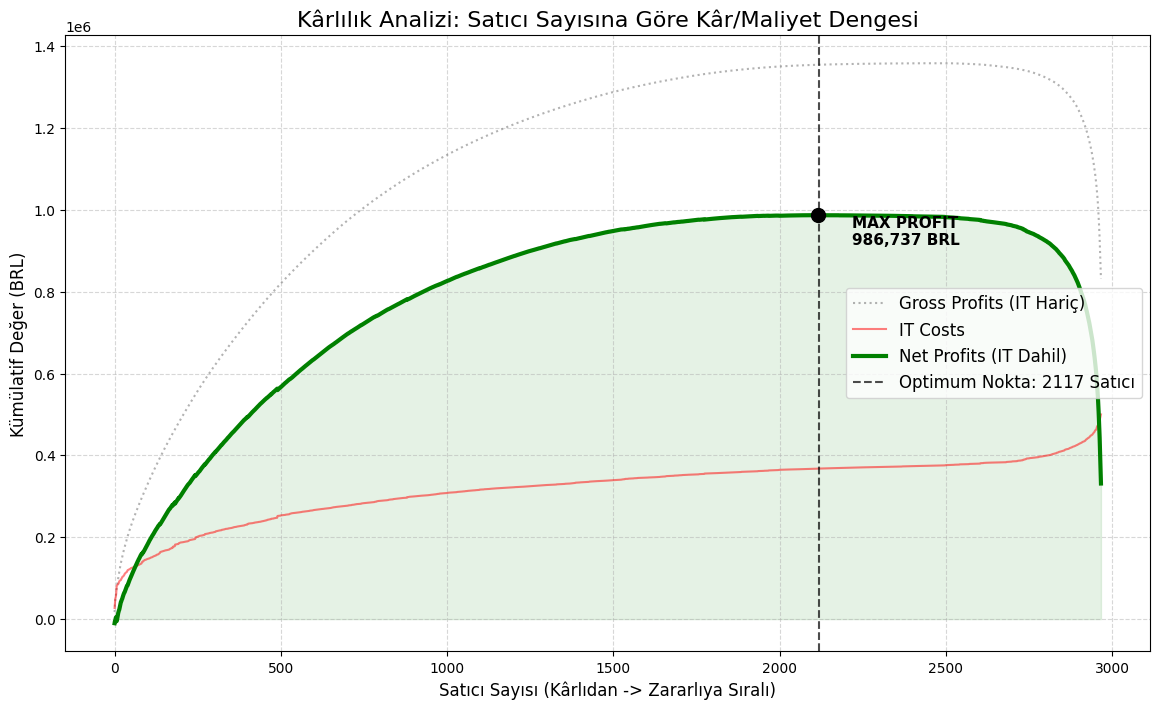

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Veri Hazırlığı ve Hesaplamalar ---

# Veriyi kârı en yüksekten en düşüğe doğru sıralıyoruz
sellers_sorted = sellers.sort_values(by='profits', ascending=False).reset_index(drop=True)

# Kümülatif hesaplamalar
sellers_sorted['cum_quantity'] = sellers_sorted['quantity'].cumsum()
sellers_sorted['cum_sellers'] = np.arange(1, len(sellers_sorted) + 1)
sellers_sorted['cum_profits_gross'] = sellers_sorted['profits'].cumsum() # Brüt Kâr

# IT Maliyeti Fonksiyonu
def calculate_it_costs(n_sellers, n_items, total_global_it_costs=500000):
    total_sellers_count = sellers['seller_id'].nunique()
    total_items_count = sellers['quantity'].sum()
    scaling_factor = total_global_it_costs / (np.sqrt(total_sellers_count) + np.sqrt(total_items_count))
    return scaling_factor * (np.sqrt(n_sellers) + np.sqrt(n_items))

# IT Maliyeti ve Net Kâr Hesabı
sellers_sorted['cum_it_costs'] = calculate_it_costs(sellers_sorted['cum_sellers'], sellers_sorted['cum_quantity'])
sellers_sorted['cum_profits_net'] = sellers_sorted['cum_profits_gross'] - sellers_sorted['cum_it_costs']

# Optimum Noktayı Bulma (Maksimum Net Kâr)
idx_max = np.argmax(sellers_sorted['cum_profits_net'])
optimum_seller_count = idx_max + 1
remove_count = len(sellers) - optimum_seller_count
max_profit_value = sellers_sorted.loc[idx_max, 'cum_profits_net']
current_profit_value = sellers_sorted['cum_profits_net'].iloc[-1]

# --- 2. Analiz Sonuçlarını Yazdırma (Text Report) ---
print("=" * 60)
print("             📉 OLIST SATICI OPTİMİZASYON RAPORU             ")
print("=" * 60)
print(f"✅ Tutulması Gereken Optimum Satıcı Sayısı : {optimum_seller_count}")
print(f"❌ Platformdan Çıkarılması Gereken         : {remove_count}")
print(f"📊 Çıkarılacak Satıcı Oranı                : %{(remove_count / len(sellers) * 100):.1f}")
print("-" * 60)
print(f"💰 Optimize Edilmiş Tahmini Net Kâr        : {max_profit_value:,.2f} BRL")
print(f"📉 Mevcut Durumdaki Net Kâr                : {current_profit_value:,.2f} BRL")
print(f"🚀 Potansiyel Kâr Artışı                   : {max_profit_value - current_profit_value:,.2f} BRL")
print("=" * 60)

# --- 3. Grafik Çizimi (Visualization) ---
plt.figure(figsize=(14, 8))

# 1. Çizgi: Brüt Kâr (IT Öncesi - Gri Kesik Çizgi)
plt.plot(sellers_sorted['cum_profits_gross'], label='Gross Profits (IT Hariç)', color='gray', linestyle=':', alpha=0.6)

# 2. Çizgi: IT Maliyetleri (Kırmızı)
plt.plot(sellers_sorted['cum_it_costs'], label='IT Costs', color='red', alpha=0.5)

# 3. Çizgi: Net Kâr (Yeşil - Ana Odak)
plt.plot(sellers_sorted['cum_profits_net'], label='Net Profits (IT Dahil)', color='green', linewidth=3)

# Optimum Noktayı İşaretleme
plt.axvline(optimum_seller_count, color='black', linestyle='--', alpha=0.7, label=f'Optimum Nokta: {optimum_seller_count} Satıcı')
plt.scatter(idx_max, max_profit_value, color='black', s=100, zorder=5) # Zirve noktası

# Grafiğe metin ekleme (Annotation)
plt.text(optimum_seller_count + 100, max_profit_value, 
         f'MAX PROFIT\n{max_profit_value:,.0f} BRL', 
         verticalalignment='top', fontsize=11, fontweight='bold')

# Eksenler ve Başlık
plt.title("Kârlılık Analizi: Satıcı Sayısına Göre Kâr/Maliyet Dengesi", fontsize=16)
plt.xlabel("Satıcı Sayısı (Kârlıdan -> Zararlıya Sıralı)", fontsize=12)
plt.ylabel("Kümülatif Değer (BRL)", fontsize=12)
plt.legend(fontsize=12, loc='center right')
plt.grid(True, linestyle='--', alpha=0.5)

# Alan Boyama (Kâr Bölgesi)
plt.fill_between(range(len(sellers_sorted)), 0, sellers_sorted['cum_profits_net'], color='green', alpha=0.1)

plt.show()

### **3. Olist, En Kötü Performans Gösteren Ürün Kategorilerini Kaldırmalı mı?**

*Bazı kategoriler doğası gereği sorunludur (örneğin kırılabilir eşyalar veya bedeni uymayan kıyafetler). Eğer bir kategorinin ortalama review puanı çok düşükse, Olist bu kategoriyi tamamen kapatmayı veya bu kategoride sadece "Premium" satıcılara izin vermeyi düşünebilir.*

--- En Kötü Performans Gösteren 10 Kategori ---
                               review_score  total_orders
product_category_name_english                            
office_furniture                   3.493183          1687
fashion_male_clothing              3.641221           131
fixed_telephony                    3.683206           262
audio                              3.825485           361
home_confort                       3.829885           435
construction_tools_safety          3.844560           193
bed_bath_table                     3.895663         11137
furniture_decor                    3.903493          8331
furniture_living_room              3.904382           502
computers_accessories              3.930819          7849


/tmp/ipykernel_76539/3734629543.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=worst_categories['review_score'], y=worst_categories.index, palette='magma')


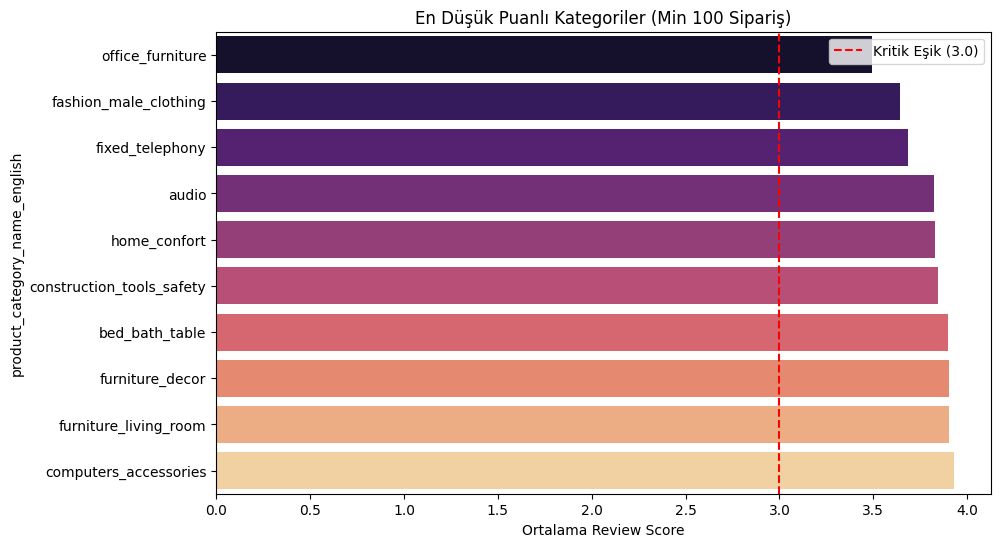

In [7]:
# Gerekli verileri birleştir
products = seller.data['products']
items = seller.data['order_items']
reviews = seller.data['order_reviews']
category_translation = seller.data['product_category_name_translation']

# Merge zinciri
merged_products = items.merge(products, on='product_id')
merged_products = merged_products.merge(reviews, on='order_id')
merged_products = merged_products.merge(category_translation, on='product_category_name')

# Kategori bazlı analiz
category_analysis = merged_products.groupby('product_category_name_english').agg({
    'review_score': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'total_orders'})

# En az 100 sipariş almış ve en kötü puana sahip 10 kategori
worst_categories = category_analysis[category_analysis['total_orders'] > 100].sort_values('review_score').head(10)

print("--- En Kötü Performans Gösteren 10 Kategori ---")
print(worst_categories)

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x=worst_categories['review_score'], y=worst_categories.index, palette='magma')
plt.title("En Düşük Puanlı Kategoriler (Min 100 Sipariş)")
plt.xlabel("Ortalama Review Score")
plt.axvline(3.0, color='red', linestyle='--', label='Kritik Eşik (3.0)')
plt.legend()
plt.show()

### **4. Olist, "Balayı Dönemi"nden Sonra Düşük Performans Gösterenleri Kaldırmalı mı?**

*Yeni satıcılar platforma alışırken hatalar yapabilir. Ancak veriler, kötü satıcıların genellikle "ilk günden itibaren" kötü olduğunu mu, yoksa zamanla mı bozulduğunu gösteriyor? 6 aydan kısa süredir var olan satıcılarla, eski satıcıların kâr dağılımını kıyaslayarak bir "Grace Period" (Hoşgörü Süresi) stratejisi belirleyebiliriz.*

                 profits  share_of_one_stars  seller_id
tenure_group                                           
Eski (6+ Ay)  496.754867            0.129123       1187
Yeni (<6 Ay)  135.739025            0.125304       1780


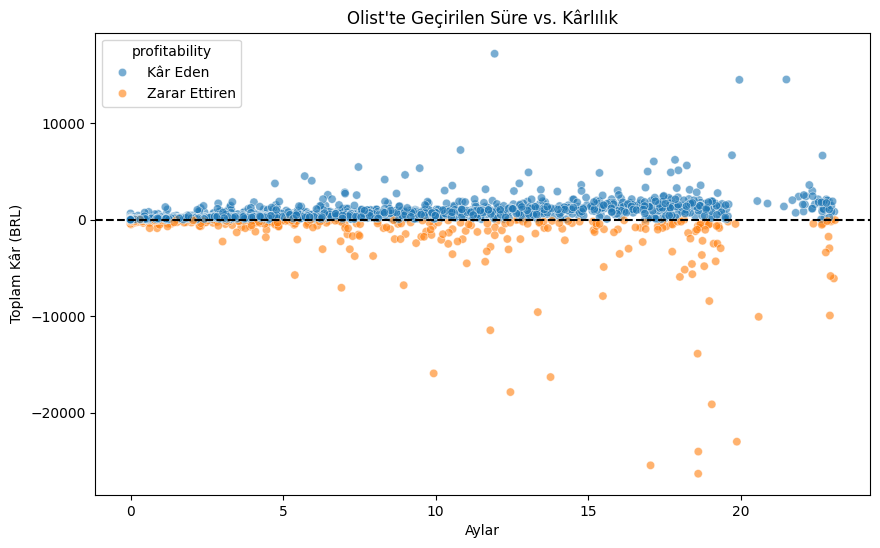

In [8]:
# Satıcıları "Yeni" (< 6 ay) ve "Eski" (>= 6 ay) olarak ayıralım
sellers['tenure_group'] = sellers['months_on_olist'].apply(lambda x: 'Yeni (<6 Ay)' if x < 6 else 'Eski (6+ Ay)')

# Gruplara göre ortalama kâr ve review skorları
tenure_analysis = sellers.groupby('tenure_group').agg({
    'profits': 'mean',
    'share_of_one_stars': 'mean',
    'seller_id': 'count'
})

print(tenure_analysis)

# Scatter plot: Süre vs Kâr
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sellers, x='months_on_olist', y='profits', hue='profitability', alpha=0.6)
plt.title("Olist'te Geçirilen Süre vs. Kârlılık")
plt.xlabel("Aylar")
plt.ylabel("Toplam Kâr (BRL)")
plt.axhline(0, color='black', linestyle='--')
plt.show()

### **5. Olist, Ürün Bilgilerini Zorunlu Kılmalı mı?**

*Eksik ürün açıklamaları veya yetersiz fotoğraf sayısı, müşterinin beklentisini yönetememeye ve dolayısıyla kötü yorumlara yol açabilir. Bu hipotezi test etmek için fotoğraf sayısı ile review skoru arasındaki korelasyona bakmalıyız.*

--- Korelasyon Matrisi ---
                            review_score  product_photos_qty  \
review_score                    1.000000            0.022626   
product_photos_qty              0.022626            1.000000   
product_description_lenght      0.013161            0.118355   

                            product_description_lenght  
review_score                                  0.013161  
product_photos_qty                            0.118355  
product_description_lenght                    1.000000  


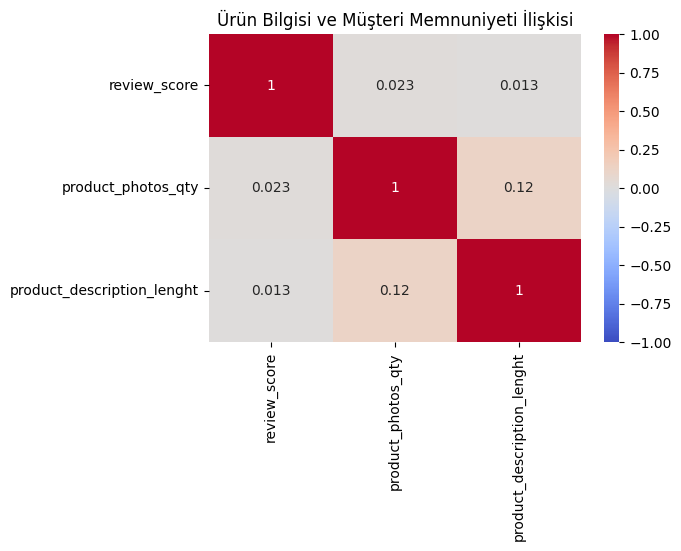

In [9]:
# Ürün özellikleri ile review skorlarını birleştir
product_features = products[['product_id', 'product_photos_qty', 'product_description_lenght']]
analysis_df = items.merge(product_features, on='product_id').merge(reviews, on='order_id')

# Korelasyon Matrisi
corr_matrix = analysis_df[['review_score', 'product_photos_qty', 'product_description_lenght']].corr()

print("--- Korelasyon Matrisi ---")
print(corr_matrix)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ürün Bilgisi ve Müşteri Memnuniyeti İlişkisi")
plt.show()

### **6. Olist, Günün Belirli Saatlerinde Satın Alma Onayı İstemeli mi?**

*Gece geç saatlerde (örneğin 23:00 - 06:00 arası) yapılan alışverişler "dürtüsel" (impulsive) olabilir ve pişmanlık/iptal oranı daha yüksek olabilir. Eğer bu saatlerde review skorları düşükse, "Emin misiniz?" uyarısı konulabilir.*

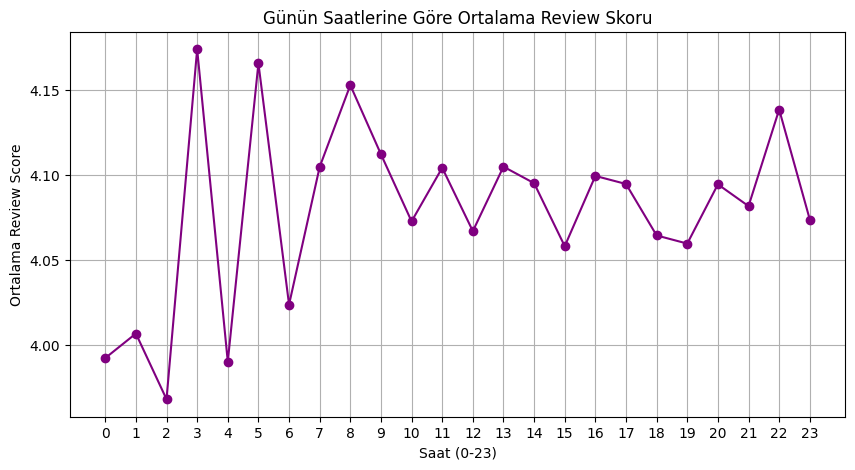

In [10]:
# Sipariş saatini çek
orders = seller.data['orders'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['hour'] = orders['order_purchase_timestamp'].dt.hour

# Review verisiyle birleştir
hourly_reviews = orders.merge(reviews, on='order_id')

# Saatlik ortalama skor
hourly_analysis = hourly_reviews.groupby('hour')['review_score'].mean()

# Görselleştirme
plt.figure(figsize=(10, 5))
hourly_analysis.plot(kind='line', marker='o', color='purple')
plt.title("Günün Saatlerine Göre Ortalama Review Skoru")
plt.xlabel("Saat (0-23)")
plt.ylabel("Ortalama Review Score")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

### **7. Olist, Belirli Eyaletler Arasındaki Satışı Kısıtlamalı mı? (Geo-Blocking)**

*Brezilya çok büyük bir ülke. Kuzeyden güneye kargo gönderimi hem çok pahalı hem de çok uzun sürüyor (yüksek wait_time). Belirli Eyalet çiftleri (Seller State -> Customer State) sürekli zarar ettiriyorsa, bu rotalar kapatılabilir.*

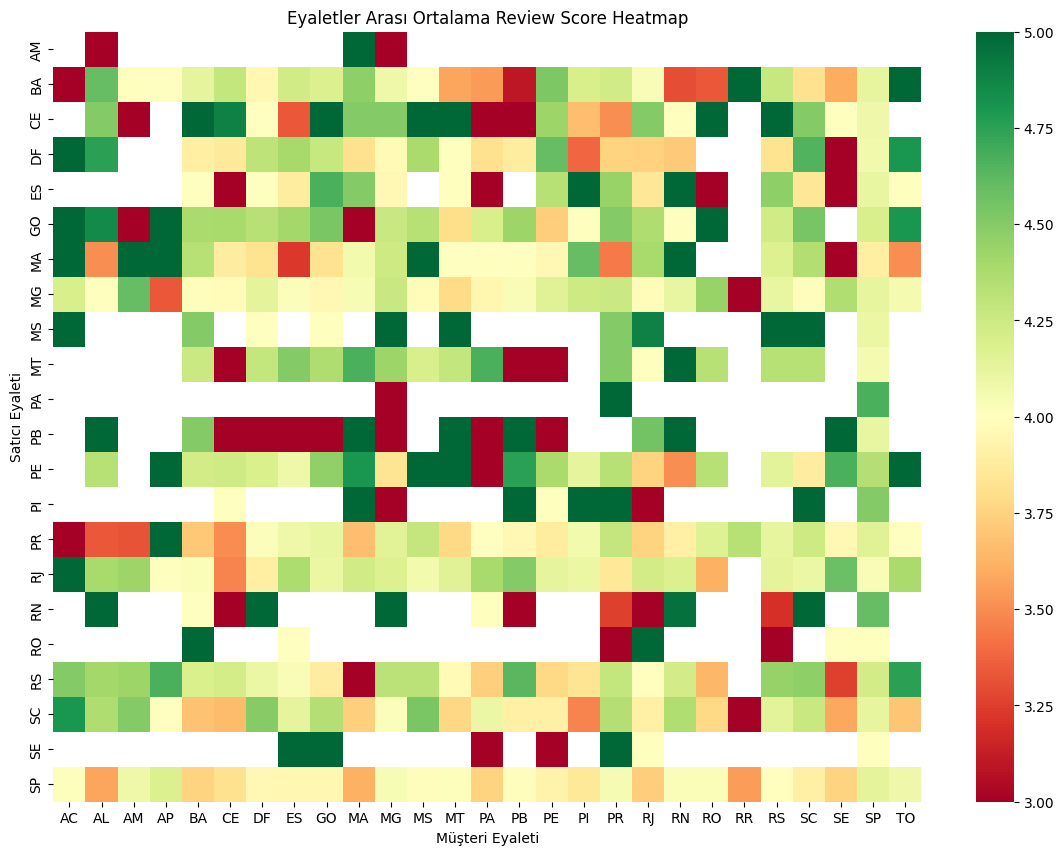

In [11]:
# Müşteri ve Satıcı lokasyonlarını birleştir
customers = seller.data['customers'][['customer_id', 'customer_state']]
geo_data = items.merge(orders, on='order_id')\
                .merge(sellers[['seller_id', 'seller_state']], on='seller_id')\
                .merge(customers, on='customer_id')\
                .merge(reviews, on='order_id')

# Eyalet Çifti (Route) oluştur
geo_data['route'] = geo_data['seller_state'] + '-' + geo_data['customer_state']

# Rota bazlı analiz (En az 50 sipariş olan rotalar)
route_analysis = geo_data.groupby(['seller_state', 'customer_state']).agg({
    'review_score': 'mean',
    'freight_value': 'mean',
    'order_id': 'count'
}).reset_index()

# Pivot table for Heatmap (Review Score)
pivot_review = route_analysis.pivot(index='seller_state', columns='customer_state', values='review_score')

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_review, cmap='RdYlGn', vmin=3, vmax=5) # Kırmızı (Kötü) -> Yeşil (İyi)
plt.title("Eyaletler Arası Ortalama Review Score Heatmap")
plt.xlabel("Müşteri Eyaleti")
plt.ylabel("Satıcı Eyaleti")
plt.show()

### **8. Olist, Yeni Satıcı Kazanım Stratejisini Nasıl Kurgulamalı?**

*Mevcut satıcıların ortalama ömür boyu değeri (LTV - burada kabaca toplam kâr olarak alabiliriz) nedir? Olist, bir satıcıyı kazanmak için (reklam, onboarding vs.) ne kadar harcayabilir?*

In [12]:
# Kâr eden satıcıların ortalama kârı (LTV proxy)
profitable_sellers = sellers[sellers['profits'] > 0]
avg_profit_per_good_seller = profitable_sellers['profits'].mean()

# Tüm satıcılar dahil ortalama (Riskli)
avg_profit_all = sellers['profits'].mean()

print(f"Kâr Eden Bir Satıcının Ortalama Getirisi (LTV Tahmini): {avg_profit_per_good_seller:,.2f} BRL")
print(f"Genel Ortalama Satıcı Getirisi: {avg_profit_all:,.2f} BRL")
print("-" * 50)
print("Öneri: Olist, yeni bir satıcıyı bünyesine katmak için (CAC)")
print(f"ortalama {avg_profit_all:.2f} BRL'ye kadar harcama yapabilir.")
print("Ancak 'kötü' satıcıları erkenden eleyebilirse bu bütçe artabilir.")

Kâr Eden Bir Satıcının Ortalama Getirisi (LTV Tahmini): 545.38 BRL
Genel Ortalama Satıcı Getirisi: 280.17 BRL
--------------------------------------------------
Öneri: Olist, yeni bir satıcıyı bünyesine katmak için (CAC)
ortalama 280.17 BRL'ye kadar harcama yapabilir.
Ancak 'kötü' satıcıları erkenden eleyebilirse bu bütçe artabilir.


## Sıra Sende!

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪